# Decision explanation

In [1]:
import os
from pathlib import Path

import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from IPython.display import Image, Markdown, display

from dreamerv2.models.rssm import RSSMDiscState
from dreamerv2.training.config import MinAtarConfig
from dreamerv2.training.evaluator import Evaluator
from dreamerv2.utils.wrapper import GymMinAtar, OneHotAction, freewayPOMDP

env_name = "freeway"
exp_id = "0_pomdp"
device = "cuda:0"
Path('freeway_expl').mkdir(exist_ok=True)

ACTIONS = {
    0: "STAY",
    1: "UP",
    2: "DOWN",
}


def render_freeway(obs):
    buf = np.zeros((10, 10, 3), dtype=np.uint8)
    buf[obs[0]] = (255, 255, 255)
    buf[obs[1]] = (255, 0, 0)
    return buf

In [2]:
env = freewayPOMDP(OneHotAction(GymMinAtar(env_name)))
result_dir = os.path.join("../results_official", f"{env_name}_{exp_id}")
model_dir = os.path.join(result_dir, "models")
f = "models_best.pth"

config = MinAtarConfig(
    env=env_name,
    obs_shape=env.observation_space.shape,
    action_size=env.action_space.shape[0],
    obs_dtype=bool,
    action_dtype=np.float32,
    model_dir=model_dir,
    eval_episode=10,
    eval_render=False,
)

evaluator = Evaluator(config, device)
evaluator.load_model(evaluator.config, os.path.join(model_dir, f))

evaluator.ObsEncoder.eval()
evaluator.ObsDecoder.eval()
evaluator.RSSM.eval()
evaluator.ActionModel.eval()

for p in evaluator.ObsEncoder.parameters():
    p.requires_grad_(False)
for p in evaluator.ObsDecoder.parameters():
    p.requires_grad_(False)
for p in evaluator.RSSM.parameters():
    p.requires_grad_(False)
for p in evaluator.ActionModel.parameters():
    p.requires_grad_(False)
    
torch.set_grad_enabled(True);

## Rollout

In [3]:
score = 0
done = False
history = []

# Produce always same episode
env = freewayPOMDP(OneHotAction(GymMinAtar(env_name)))
env.env.env.seed(12)
torch.manual_seed(13)

# [2, 10, 10]
obs = env.reset()

# Initial RSSM state (all zeros):
# state.deter [1, 200]
# state.logit [1, 400] (20 categegoricals, 20 classes each)
# state.stoch [1, 400] (20 one-hot samples, sampled from logit)
prev_rssm_state = evaluator.RSSM._init_rssm_state(batch_size=1)

# [1, 3]
prev_action = torch.zeros(1, evaluator.action_size).to(evaluator.device)

for _ in range(30):
    # Embed observation, [1, 200]
    obs = torch.from_numpy(obs).float().to(evaluator.device)
    obs.requires_grad_(True)
    embed = evaluator.ObsEncoder(obs.unsqueeze(0))

    # During evaluation, use the posterior state, i.e. the one obtained using the current observation.
    _, posterior_rssm_state = evaluator.RSSM.rssm_observe(
        embed, prev_action, not done, prev_rssm_state
    )

    # Concat deter+stoch state [1, 600]
    model_state = evaluator.RSSM.get_model_state(posterior_rssm_state)

    # The history consists of:
    # current obs         o_t
    # current state       h_t, s_t
    # predicted action    a_t
    # internal move timer (will the action actually have effect?)
    action, _ = evaluator.ActionModel(model_state)
    obs_seq_grad = torch.autograd.grad(
        action.max(), [prev_obs for prev_obs, *_ in history] + [obs], retain_graph=True
    )
    obs_seq_grad = np.stack([og.cpu().numpy() for og in obs_seq_grad], axis=0)
    history.append(
        [
            obs,
            obs_seq_grad,
            RSSMDiscState(
                posterior_rssm_state.logit.detach().cpu().squeeze(0).reshape(20, 20),
                posterior_rssm_state.stoch.detach().cpu().squeeze(0).reshape(20, 20),
                posterior_rssm_state.deter.detach().cpu().squeeze(0),
            ),
            action.detach().squeeze(0).cpu().numpy(),
            env.env.env.env.env.move_timer == 0,
        ]
    )

    obs, reward, done, _ = env.step(action.detach().squeeze(0).cpu().numpy())
    score += reward
    prev_rssm_state = posterior_rssm_state
    prev_action = action

# Detach observations and move to numpy,
# can not be done before because needed for backprop
for t in range(len(history)):
    obs = history[t][0]
    history[t][0] = obs.detach().bool().cpu().numpy()

score, len(history)

(1, 30)

## Attributions

The action $a_t$ sampled at time $t$ is attributed to the sequence $o_{\leq t}$ i.e. all observations made up to that point.

### Step 0

No gradient w.r.t. observation sequence


### Step 1

No gradient w.r.t. observation sequence


### Step 2

No gradient w.r.t. observation sequence


### Step 3

No gradient w.r.t. observation sequence


### Step 4

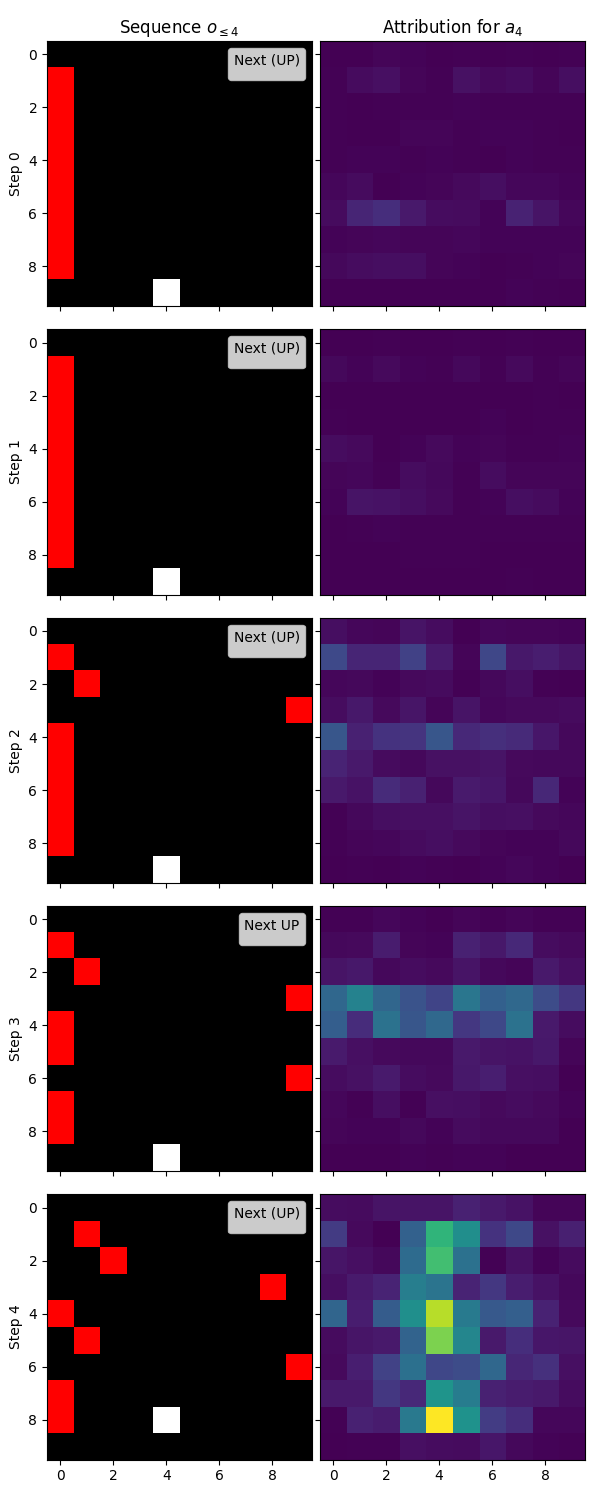

### Step 5

No gradient w.r.t. observation sequence


### Step 6

No gradient w.r.t. observation sequence


### Step 7

No gradient w.r.t. observation sequence


### Step 8

No gradient w.r.t. observation sequence


### Step 9

No gradient w.r.t. observation sequence


### Step 10

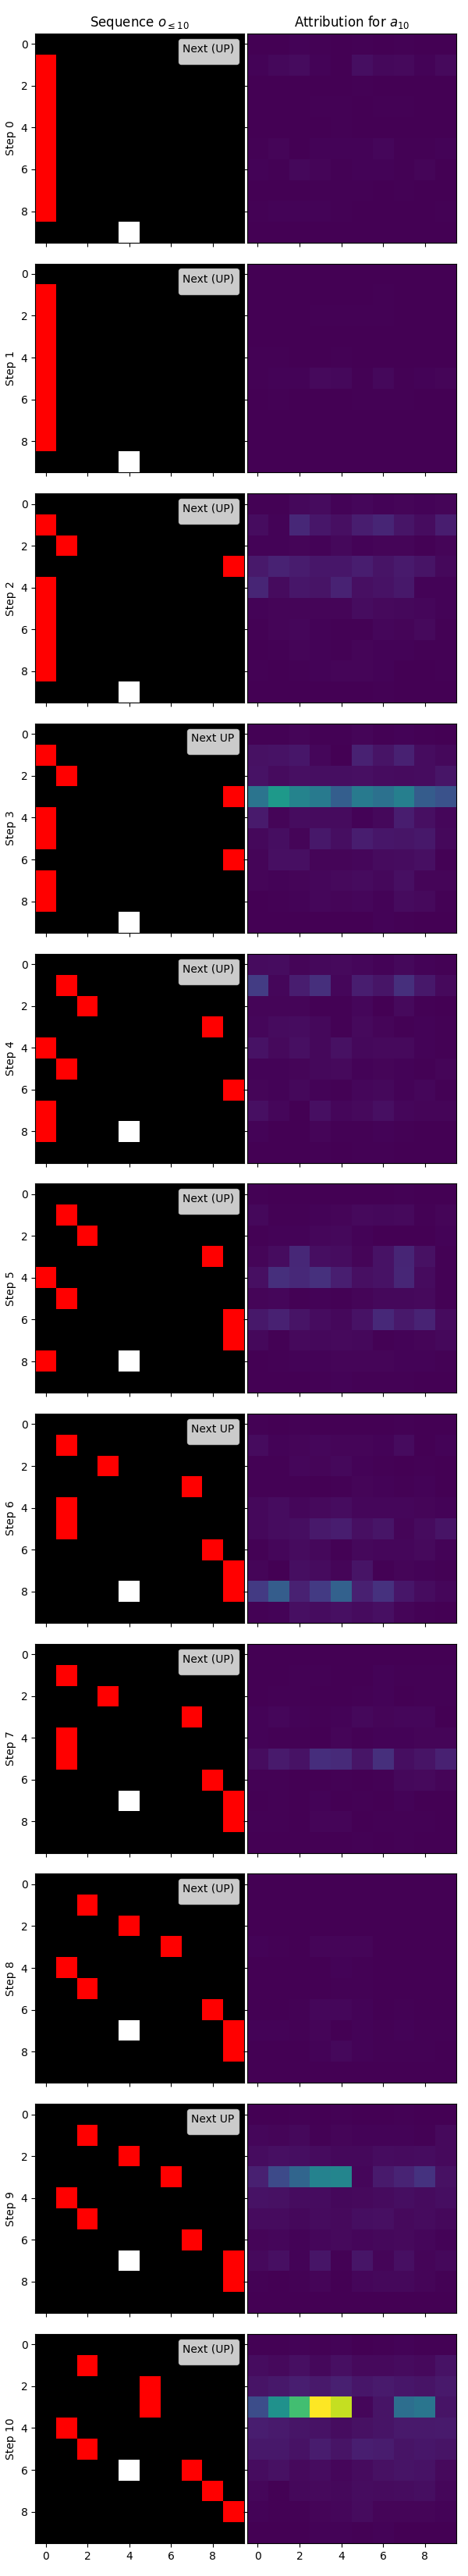

### Step 11

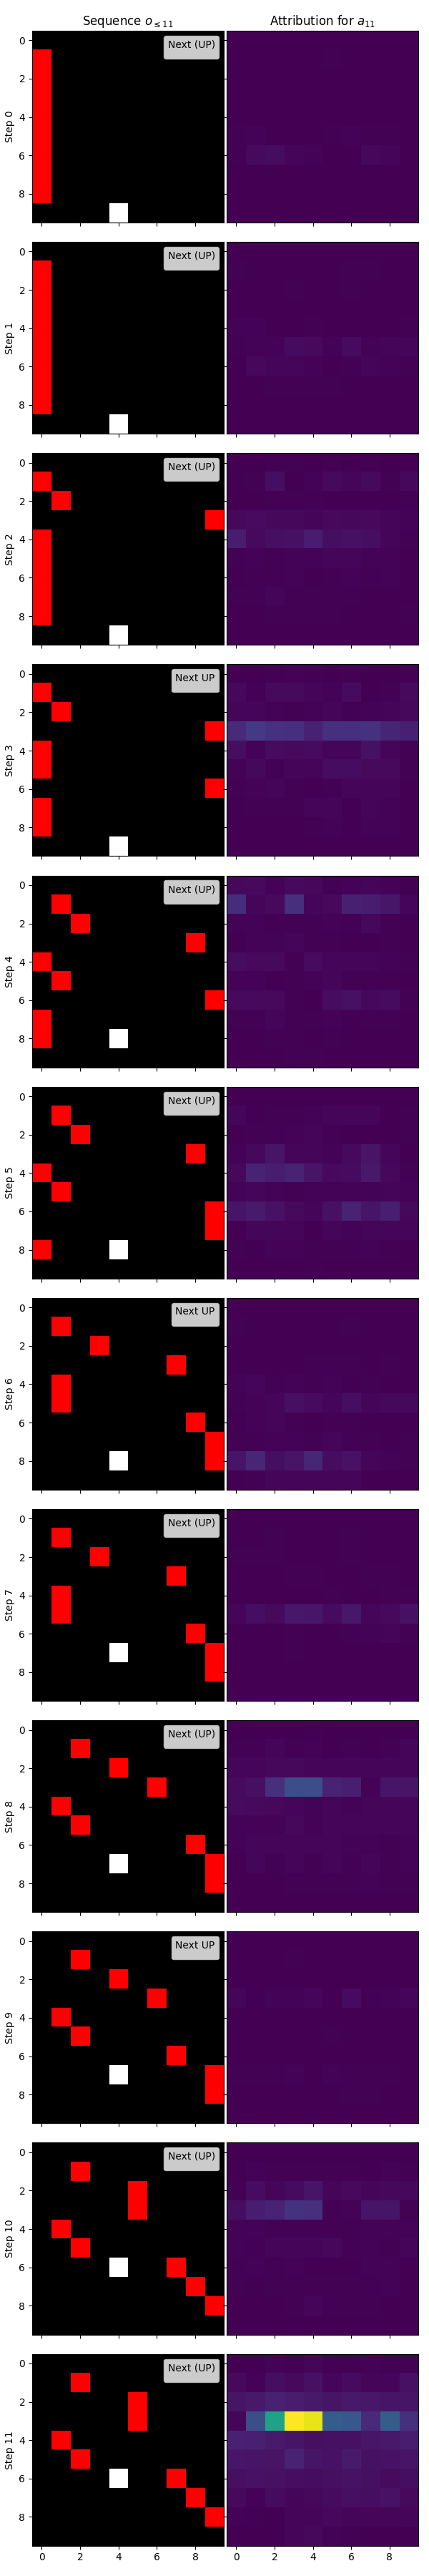

### Step 12

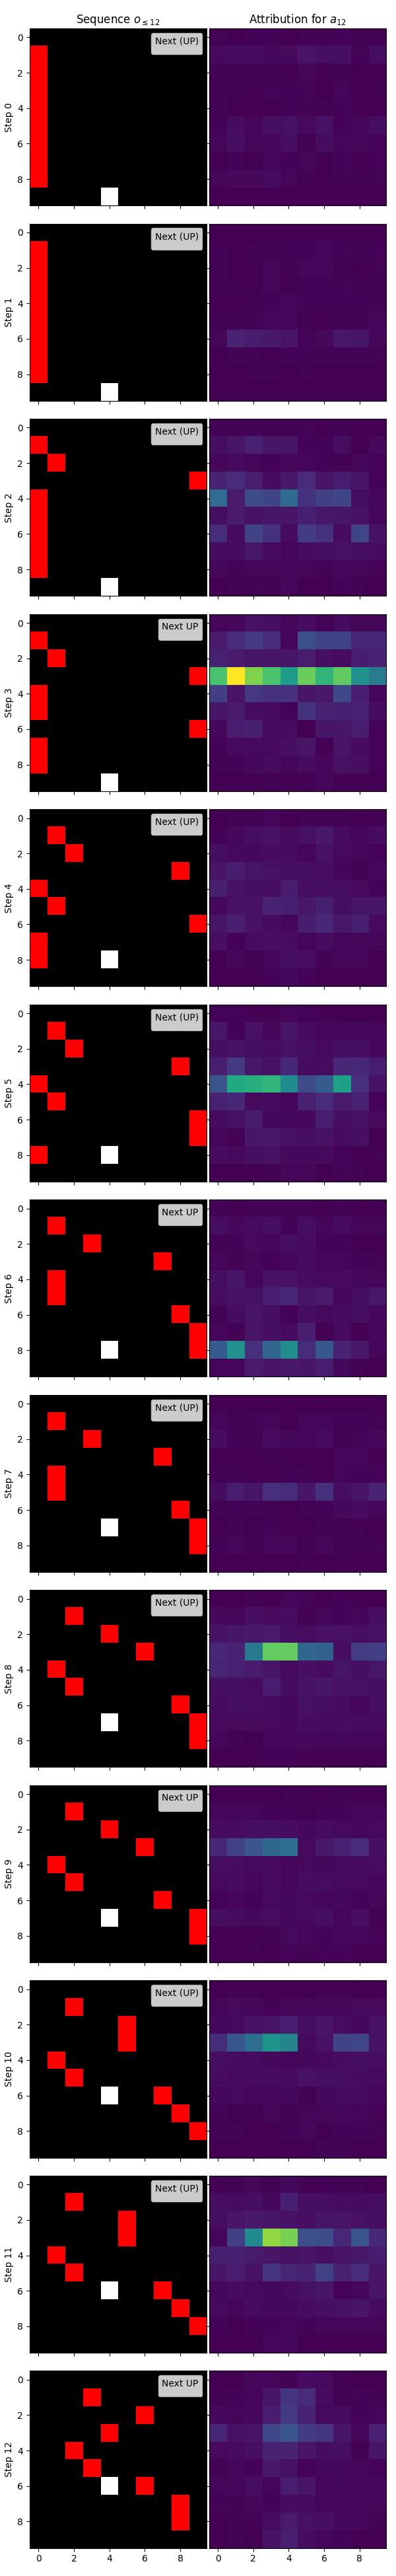

### Step 13

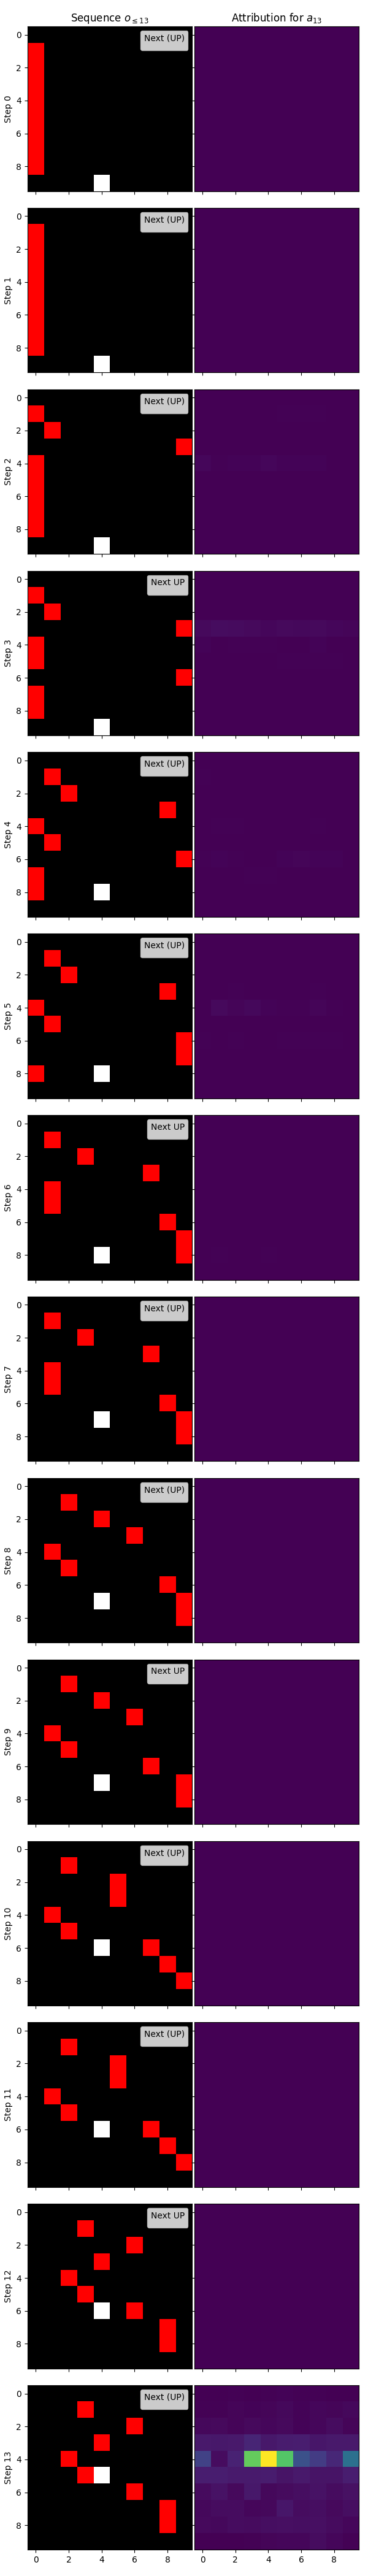

### Step 14

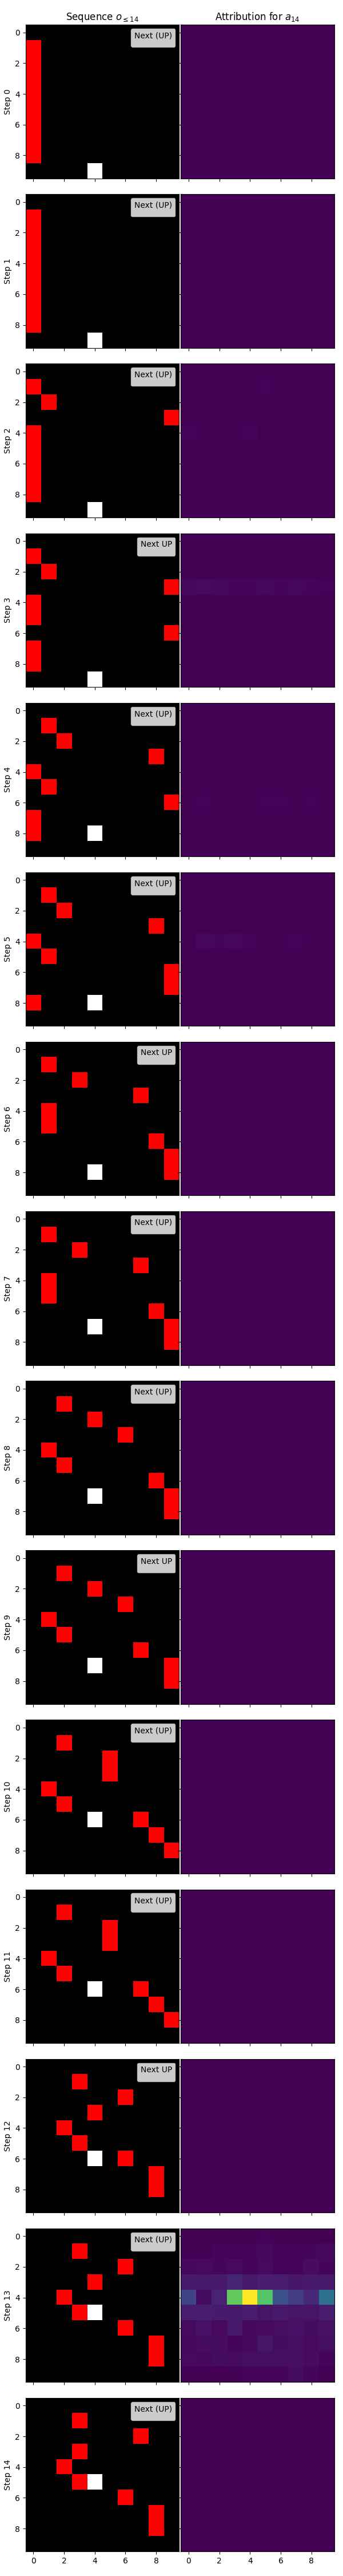

### Step 15

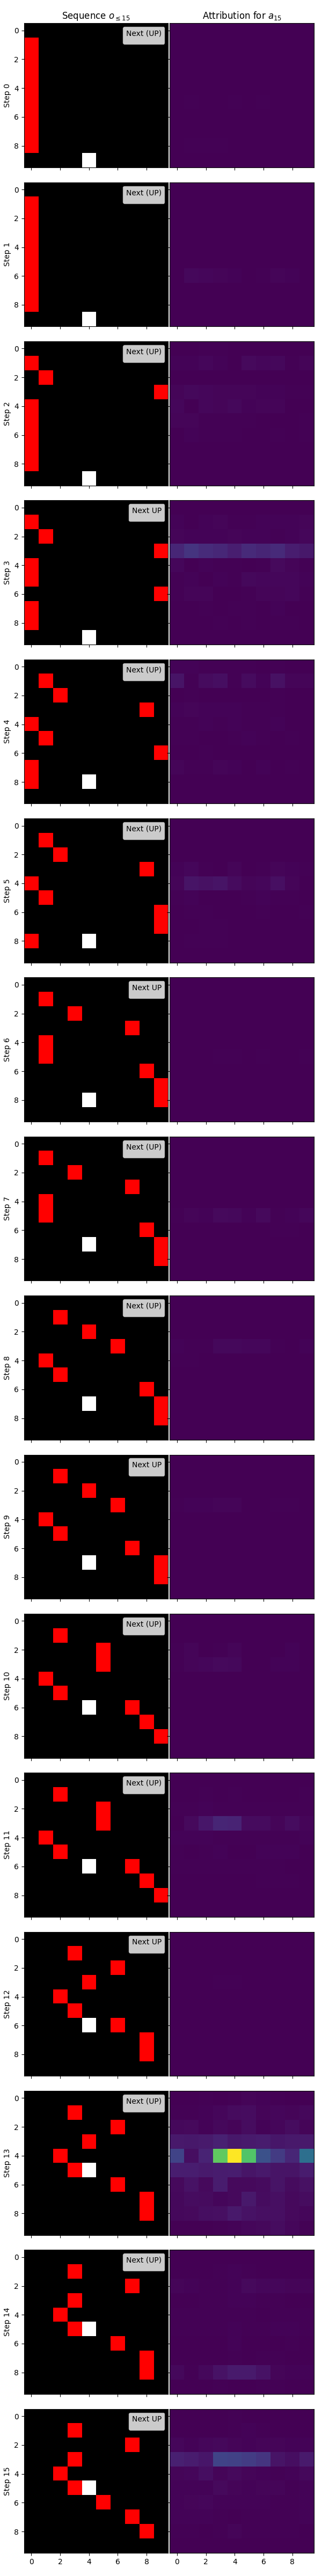

### Step 16

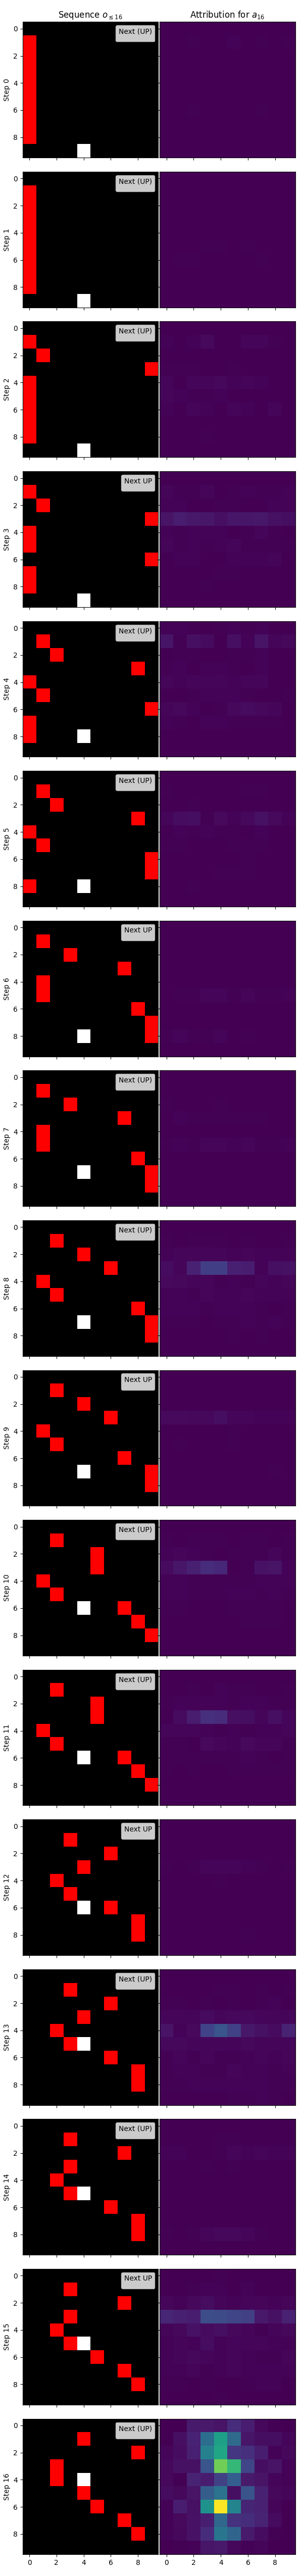

### Step 17

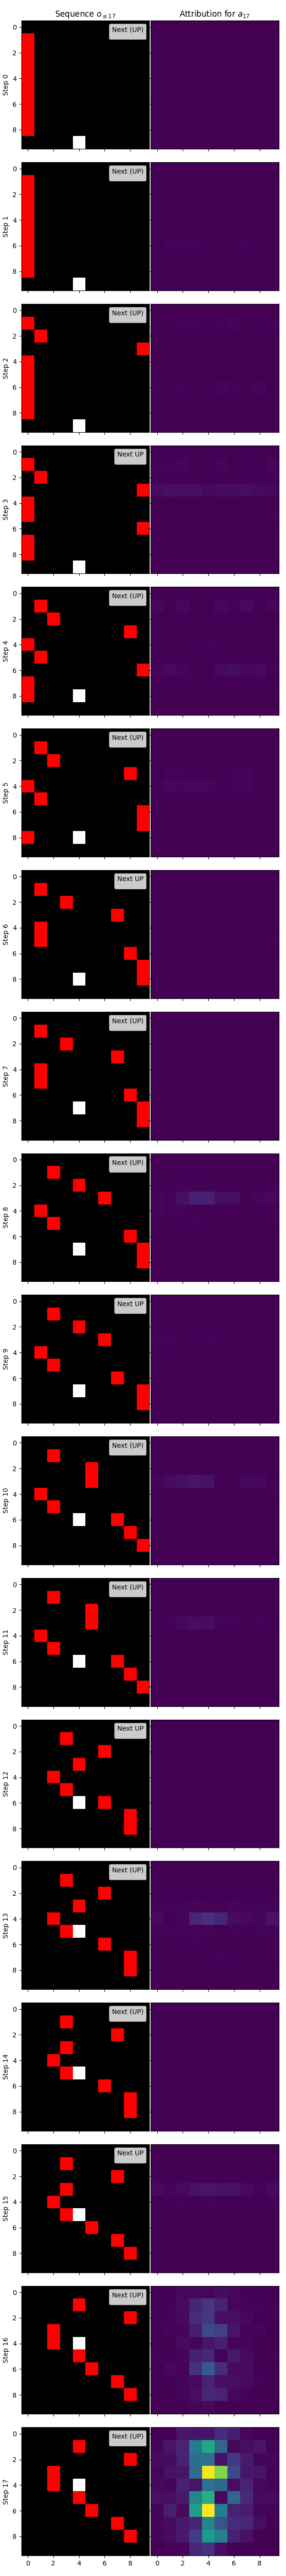

### Step 18

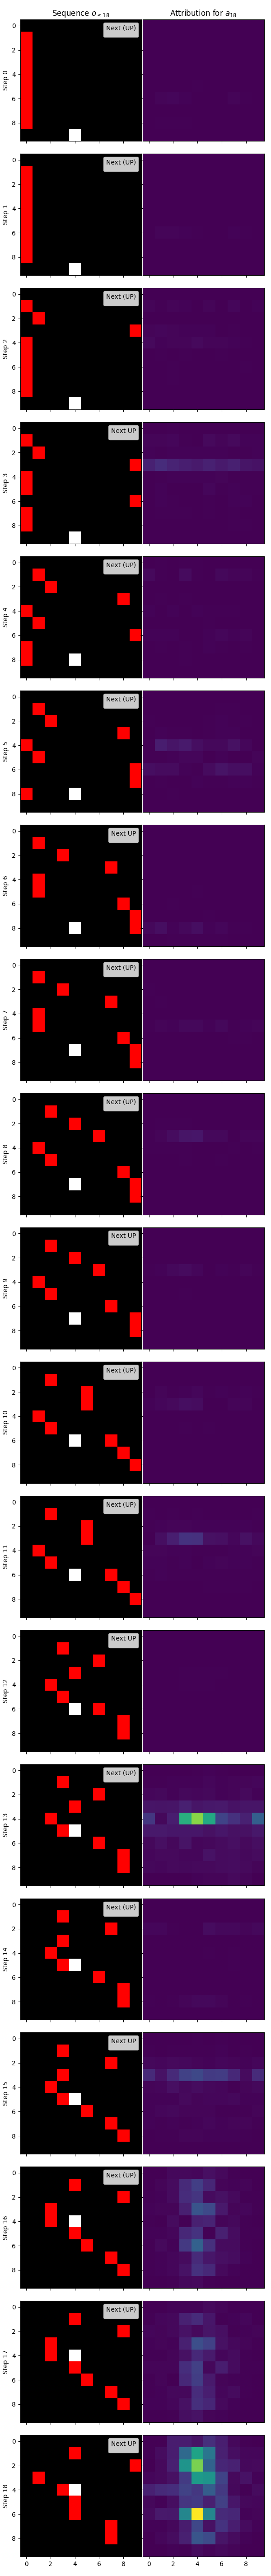

### Step 19

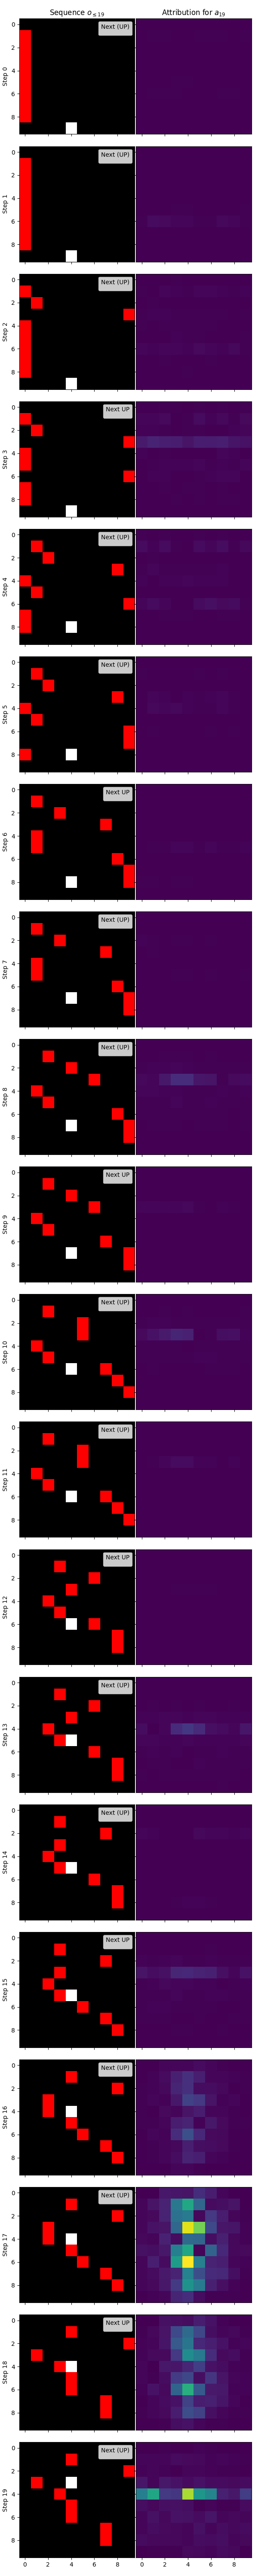

### Step 20

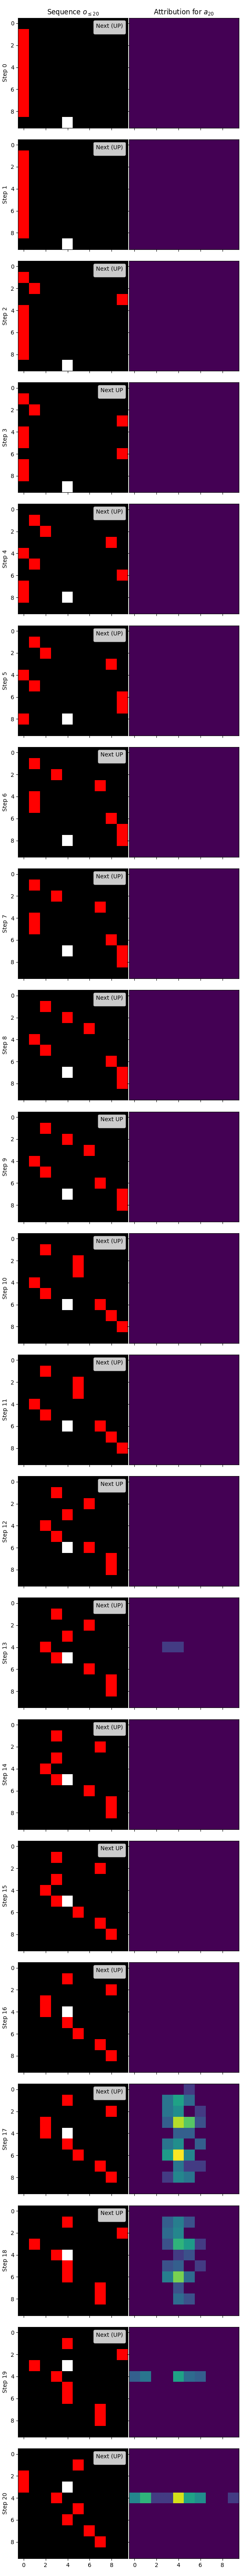

### Step 21

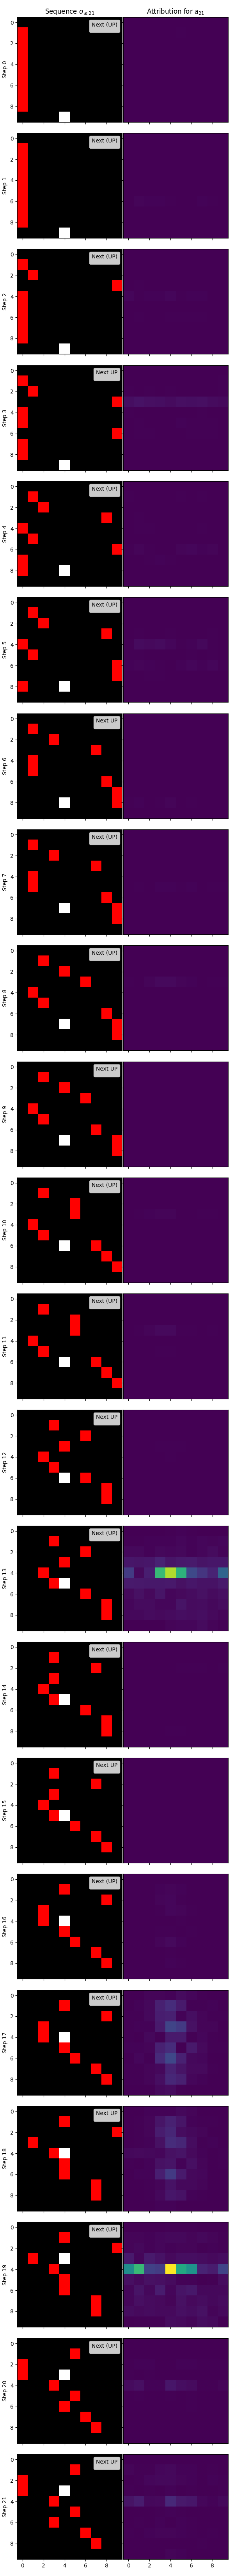

### Step 22

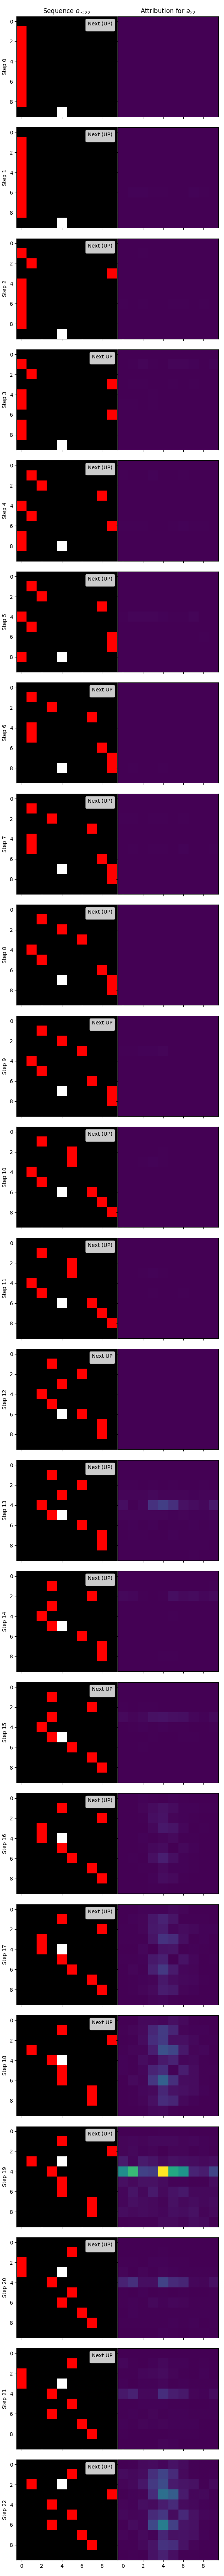

### Step 23

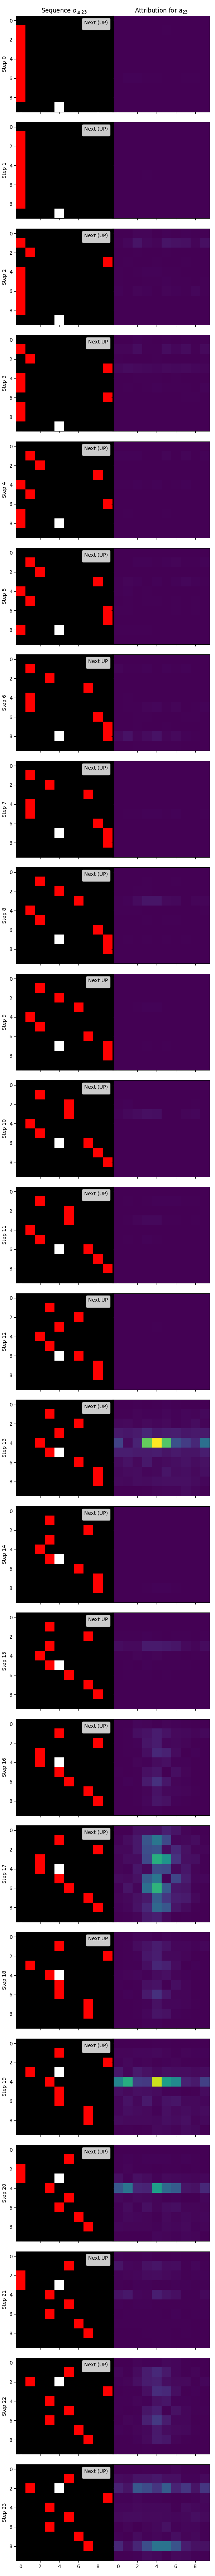

### Step 24

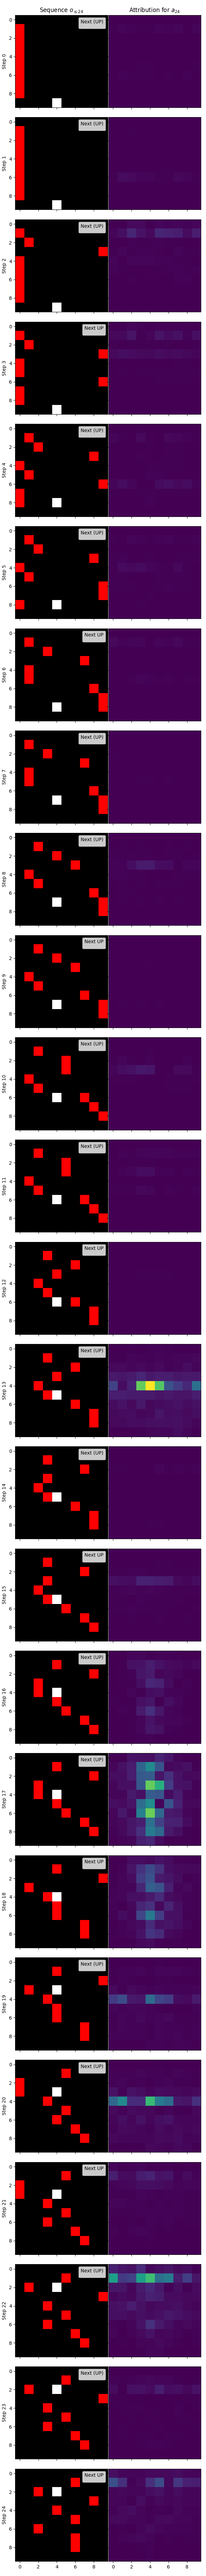

### Step 25

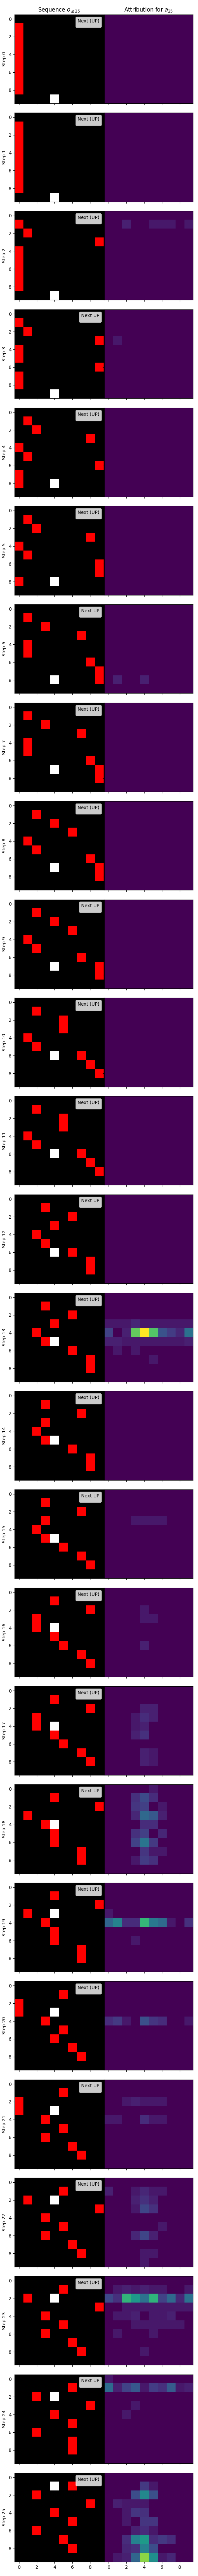

### Step 26

No gradient w.r.t. observation sequence


### Step 27

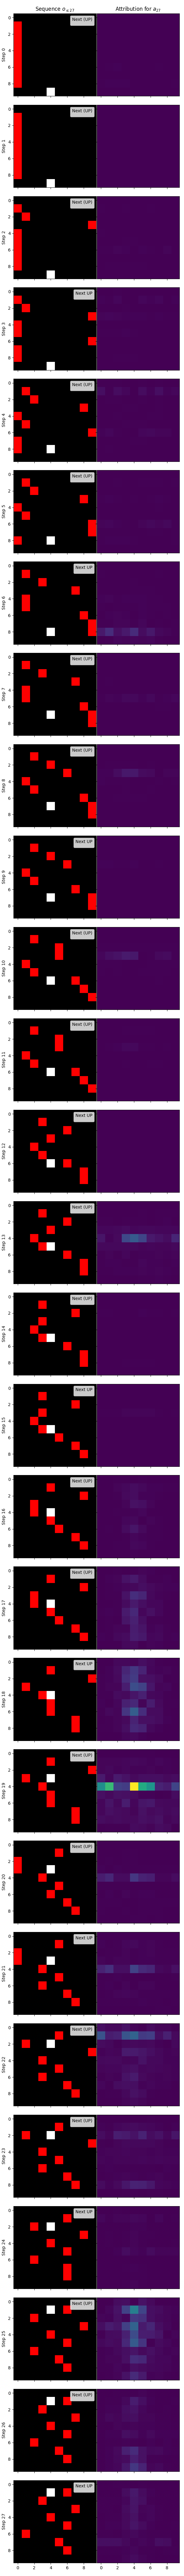

### Step 28

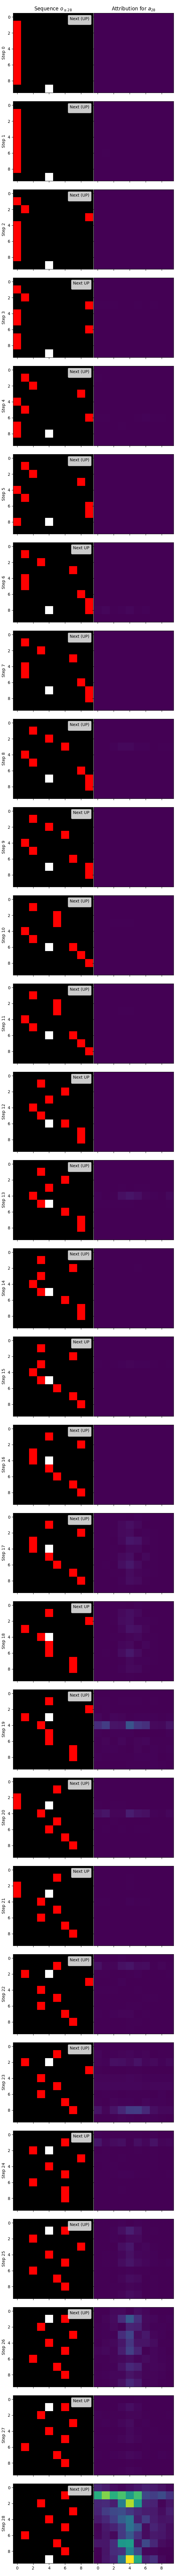

### Step 29

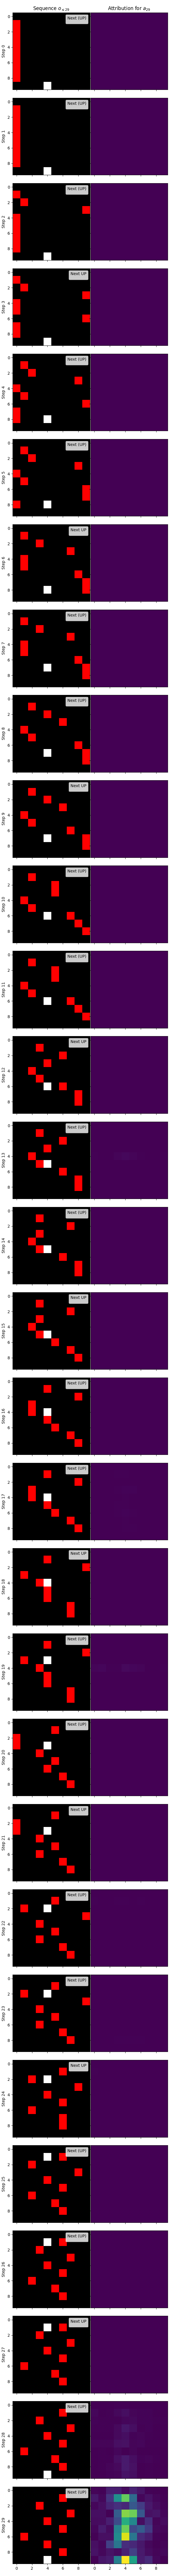

In [4]:
for t in range(len(history)):
    display(Markdown(f"### Step {t}"))
    
    _, obs_seq_grad, posterior_rssm_state, _, _ = history[t]
    attribs = np.sqrt(np.sum(obs_seq_grad ** 2, axis=1))
    if (attribs == 0).all():
        print('No gradient w.r.t. observation sequence')
        continue
    
    obs_seq = [o for o, *_ in history[: t + 1]]
    action_seq = [a.argmax() for *_, a, _ in history[: t + 1]]
    has_effect_seq = [has_effect for *_, has_effect in history[: t + 1]]

    fig, axs = plt.subplots(
        t + 1, 2, figsize=(6, 3 * (t + 1)), sharex=True, sharey=True, squeeze=False
    )
    axs[0, 0].set_title(f"Sequence $o_{{\\leq{t}}}$")
    axs[0, 1].set_title(f"Attribution for $a_{{{t}}}$")
    for tt in range(t + 1):
        ax = axs[tt, 0]
        ax.imshow(render_freeway(obs_seq[tt]))
        ax.set_ylabel(f"Step {tt}")
        ax.legend(
            [],
            loc="upper right",
            title=(
                # If the action is in () it means that it will
                # actually have no effect due to the game timer.
                f"Next {ACTIONS[action_seq[tt]]}"
                if has_effect_seq[tt]
                else f"Next ({ACTIONS[action_seq[tt]]})"
            ),
        )

        ax = axs[tt, 1]
        ax.imshow(attribs[tt], vmin=attribs.min(), vmax=attribs.max())

    fig.tight_layout()
    fig.savefig(f"freeway_expl/{t}.png")
    plt.close(fig)
    display(Image(f"freeway_expl/{t}.png"))